**Text Features**

In [63]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA
import umap 
from sklearn.manifold import  TSNE

**(a) Cluster the text features. Can you find meaningful clusters?**



**(b)Design a labeling function for classes dog and cat. Do the annotations labeled as dog or cat sounds form tight clusters in the text and audio feature space?**

**Dimensionality reduction**

In [4]:
an_df = pd.read_csv(r"C:\Users\user\Desktop\MLPC\annotations.csv")
an_df.head(2)

,task_id,filename,annotator,text,onset,offset,filename_unsafe
0,161977861,560761.mp3,5945971035380930099053858595454362549806990533...,bird twitters nearby with a high pitch two times,16.552368,17.271435,560761_tufted titmouse calling.mp3
1,161987165,240538.mp3,4916274343929406460752597829190197300566135449...,A cow bell clinging repeatedly,12.265866,15.420303,240538_AMB - Cowbell stable Stereowav.mp3


In [5]:
an_em = np.load(r"C:\Users\user\Desktop\MLPC\annotations_text_embeddings.npz")["embeddings"]

**Clustering Text Features**

In [39]:
kmeans = KMeans(15)
an_df["cluster"] = kmeans.fit_predict(an_em)

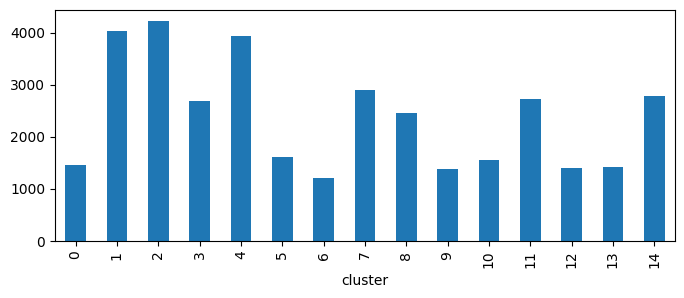

In [40]:
counts = an_df["cluster"].value_counts(sort=False).sort_index()
counts.plot(kind="bar", figsize=(8, 3))
plt.show()

In [41]:
def dog_or_cat(text_annotation):
    keywords = ["dog","cat","meow","bark"]
    return any([kw in text_annotation for kw in keywords])

In [42]:
an_df["Dog_Cat"] = an_df["text"].transform(dog_or_cat)
an_df["Dog_Cat"].value_counts()

Dog_Cat
False    33358
True      2468
Name: count, dtype: int64

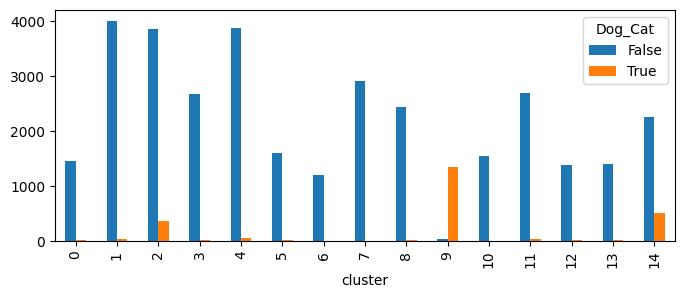

In [43]:
# goup by cluster and bad_weater, get size of eah group and then pivot bad weather from index to column
counts = an_df[["cluster", "Dog_Cat"]].groupby(["cluster", "Dog_Cat"]).size().unstack()

counts.plot(kind="bar", figsize=(8, 3))
plt.show()

In [46]:
an_df[an_df["cluster"]==9]["text"].unique()[:5]

array(['A dog is barking furiously.',
       'Dog barking loudly in the background', 'A dog barking',
       'a single dog bark', 'A dog growls'], dtype=object)

In [114]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(an_em)

<Axes: xlabel='tsne_dim1', ylabel='tsne_dim2'>

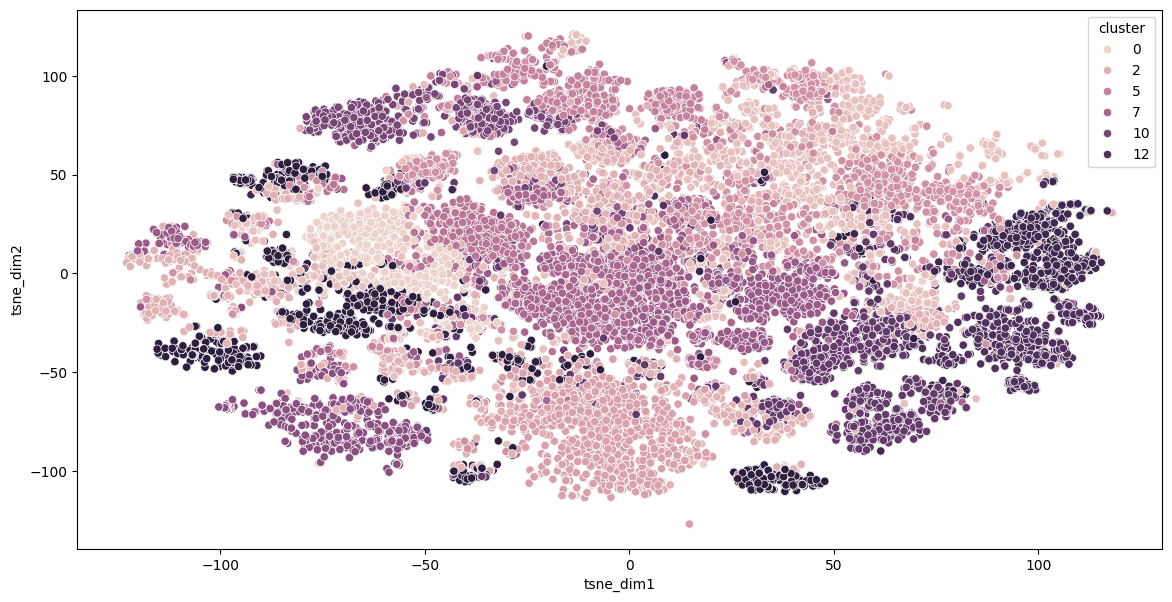

In [115]:
fig,ax = plt.subplots(figsize=(14,7))
an_df["tsne_dim1"] = tsne[:,0]
an_df["tsne_dim2"] = tsne[:,1]
an_df.head()
sns.scatterplot(x=an_df["tsne_dim1"],y=an_df["tsne_dim2"],hue=an_df["cluster"],ax=ax,legend=True)

**Clustering audio Features**

In [85]:
multi_feature_names= ["melspectrogram","mfcc"]

In [90]:
# dict keys:feature names values: sample values 
meta_df = pd.read_csv(r"C:\Users\user\Desktop\MLPC\metadata.csv")
meta_df.set_index("filename",inplace=True)
multi_features= {}
for i in multi_feature_names:
    multi_features[i] = []

for i in multi_feature_names:
    for idx, row in meta_df.iterrows():
        file_name = idx.replace("mp3", "npz")
        path_to_feature_file = os.path.join(r"C:\Users\user\Desktop\MLPC", "audio_features", file_name)
        feature = np.load(path_to_feature_file)[i]
        multi_features[i].append(feature)
    





In [107]:
mfcc_samples = multi_features['mfcc']

In [117]:
mfcc_vectors = [np.mean(mfcc, axis=0) if isinstance(mfcc, np.ndarray) else np.array(mfcc)
                for mfcc in mfcc_samples]  # shape: [n_samples, n_coeffs]

X = np.stack(mfcc_vectors) 


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

k = 15  
kmeans = KMeans(n_clusters=15, random_state=42)
labels = kmeans.fit_predict(X_scaled)

C:\Users\user\anaconda3\envs\computervision\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


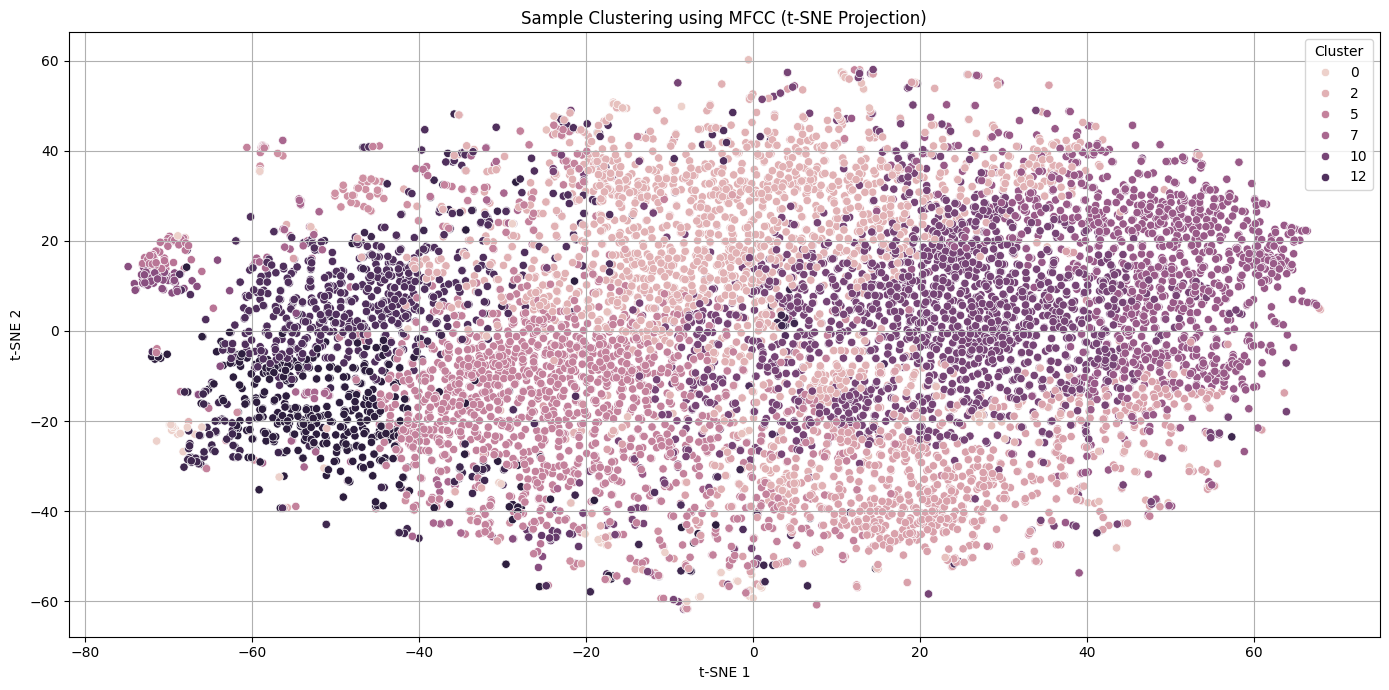

In [118]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)


fig,ax = plt.subplots(figsize=(14,7))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=labels, ax=ax)
plt.title("Sample Clustering using MFCC (t-SNE Projection)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()